In [1]:
pip install pyreadstat

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import pyreadstat 
import matplotlib.pyplot as plt
# import xgboost as xgb
from sklearn.model_selection import GridSearchCV,cross_val_score

In [3]:
df, meta= pyreadstat.read_sav("cleaned_survey.sav")

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# type(df)
# df.columns

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [7]:
x = df.loc[:,["社經地位","時間規劃","自信心","內在動機"]]
y = df.iloc[:,44]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [9]:
#n_estimators: 樹的數量
# max_depth: 每顆樹的最大深度
# learning_rate: 範圍通常在0.01-0.2之間
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40), #star, stop, step
    'learning_rate': [0.1, 0.01, 0.05]
}

regressor=xgb.XGBRegressor(objective = "reg:squarederror",nthread=4,seed=42) #thread越大 速度越快, seed 每次固定的隨機值
# try out every combination of the above values
search = GridSearchCV(
    regressor,
    param_grid,
    n_jobs = 10, #10個組合同步執行
    cv = 10, #k-fold交叉驗證10次，去找最好的參數
    verbose=2 #輸出訊息
)

search.fit(X_train, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_ca...ne, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, nthread=4,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             verbose=2)

In [10]:
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 140}


In [11]:
#也可以用search直接search.predict(X_test)，因為search 已經找到最佳參數，但不建議使用search因為他還得重新搜尋一次最好的參數組合
xgb_model=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"])


In [12]:
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=140, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [13]:
# search.predict(X_test)

In [14]:
# make predictions
train_preds = xgb_model.predict(X_train)

In [15]:
# make predictions
test_preds = xgb_model.predict(X_test)
# test_preds

In [16]:
def mape(y_true, y_pred):
    mape  = np.mean(np.abs((y_true - y_pred) / y_true)) *100
#     (絕對值(真實值-預測值)/真實值)/平均*100
    return mape

In [17]:
mape(y_train, train_preds)

11.400417203545004

In [18]:
mape(y_test, test_preds)

18.25906126996986

In [19]:
MAPE = (np.abs(y_test - test_preds) / y_test *100)
# MAPE

In [20]:
data = np.array([y_test, test_preds, MAPE])
final = pd.DataFrame(data).transpose()
# final

In [21]:
final.columns = ["true","predict","mape"]


In [22]:
final

,true,predict,mape
0,4.0,3.304814,17.379653
1,2.6,2.828615,8.792874
2,3.4,2.153583,36.659329
3,4.0,3.247121,18.821985
4,3.2,2.968453,7.235846
...,...,...,...
85,3.0,2.828615,5.712843
86,2.8,2.818657,0.666319
87,3.0,1.831180,38.960679
88,2.8,2.677450,4.376788


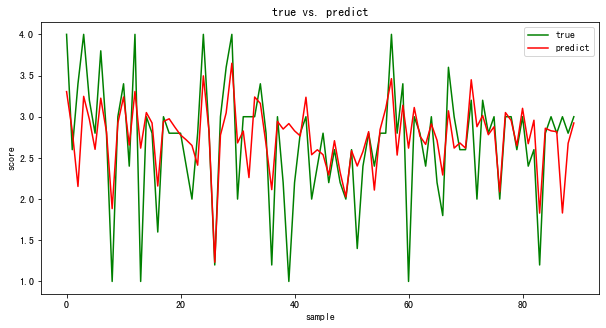

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(final.index, final.true, color='g', label ="true")
plt.xlabel('sample') # 設定x軸標題
plt.ylabel('score') # 設定y軸標題
plt.plot(final.index, final.predict,color='r',label ="predict")
plt.legend()
plt.title('true vs. predict') # 設定圖表標題
plt.show()

Text(0.5, 1.0, 'inner motivation')

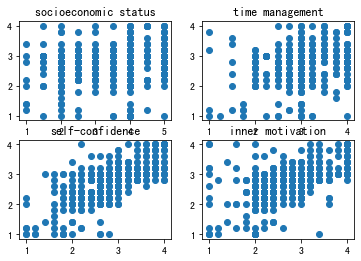

In [24]:
# 每個自變項和應變數沒有線性相關
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(df.loc[:,"社經地位"], y)
axs[0, 0].set_title("socioeconomic status")

axs[0, 1].scatter(df.loc[:,"時間規劃"], y)
axs[0, 1].set_title("time management")

axs[1, 0].scatter(df.loc[:,"自信心"], y)
axs[1, 0].set_title("self-confidence")

axs[1, 1].scatter(df.loc[:,"內在動機"], y)
axs[1, 1].set_title("inner motivation")

In [25]:
#10折交叉驗證 結果的mape值和未用交叉驗的接近
#xgb_model 已經是找好最佳參數的xgb
score = -cross_val_score(xgb_model, x,y,scoring='neg_mean_absolute_percentage_error', cv= 10) #需加 - 在前面
score*100
score.mean()

0.15103858436872503